In [25]:
import pandas as pd
import os

# Verificamos si existe el archivo (asegúrate de que esté en la misma carpeta)
if os.path.exists('matriz_similitud_svd.csv'):
    print("Cargando inteligencia del modelo SVD...")
    # index_col=0 es importante para que el ID del producto sea el índice
    df_sim_svd = pd.read_csv('matriz_similitud_svd.csv', index_col=0)
    print(f"✅ Matriz SVD cargada exitosamente: {df_sim_svd.shape}")
else:
    print("⚠️ NO se encontró 'matriz_similitud_svd.csv'.")
    print("Por favor ejecuta el PASO 1 en el otro notebook primero.")
    df_sim_svd = None # Variable vacía para evitar errores

Cargando inteligencia del modelo SVD...
✅ Matriz SVD cargada exitosamente: (2000, 2000)


In [26]:
import pandas as pd
import numpy as np

df_order_items = pd.read_csv("order_items.csv")
df_orders = pd.read_csv("orders.csv")
df_products = pd.read_csv("products.csv")

C:\Users\fredd\AppData\Local\Temp\ipykernel_30832\316383003.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df_conteo, palette='viridis')


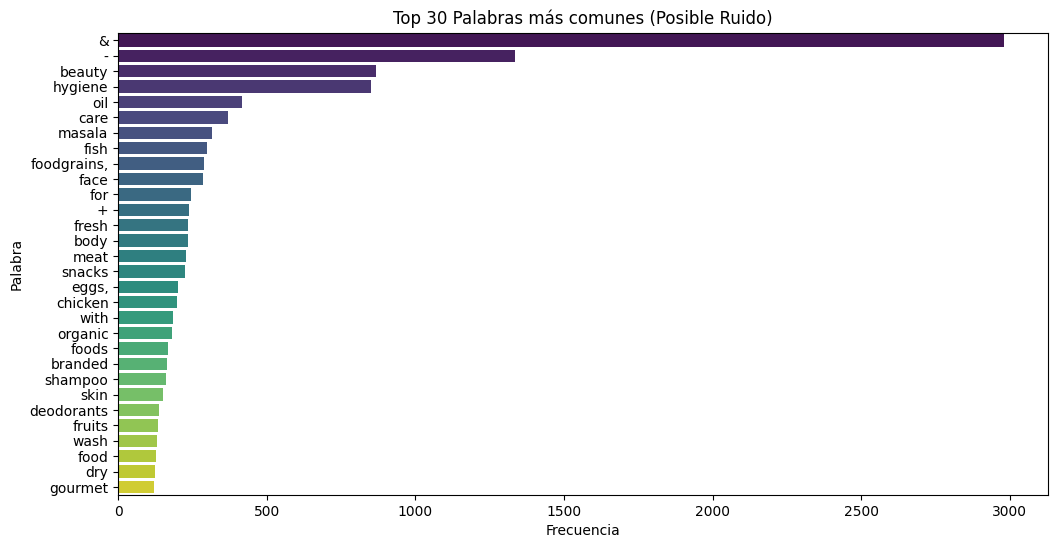

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 1. Preparar la "Sopa" (Igual que antes)
# Unimos nombre y categorías para analizar todo el texto junto
df_analisis = df_products.copy().fillna('')
df_analisis['texto_completo'] = df_analisis['ProductName'] + " " + df_analisis['Category'] + " " + df_analisis['SubCategory']

# 2. Tokenizar (Romper frases en palabras sueltas)
# Convertimos a minúsculas (.lower()) y separamos por espacios (.split())
todas_las_palabras = " ".join(df_analisis['texto_completo']).lower().split()

# 3. Contar frecuencia
conteo = Counter(todas_las_palabras)
common_words = conteo.most_common(30) # Las 30 más repetidas

# 4. Graficar para ver a los culpables
df_conteo = pd.DataFrame(common_words, columns=['Palabra', 'Frecuencia'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=df_conteo, palette='viridis')
plt.title('Top 30 Palabras más comunes (Posible Ruido)')
plt.show()

In [28]:
# Lista de palabras que TU decidiste borrar basándote en la gráfica anterior
# Agrega aquí todo lo que viste que sea ruido (unidades de medida, conectores, etc.)
mis_stop_words = ["&","-","+","with","for", 'pc', 'pcs'
]

print(f"Palabras en la lista negra: {len(mis_stop_words)}")

Palabras en la lista negra: 7


In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Cargar datos (Asegúrate de tener tu df_products cargado)
# Trabajamos con una copia para no dañar el original
df_nlp = df_products.copy().drop_duplicates(subset='product_id').reset_index(drop=True)

# Rellenar vacíos por si acaso
df_nlp['ProductName'] = df_nlp['ProductName'].fillna('')
df_nlp['Category'] = df_nlp['Category'].fillna('')
df_nlp['SubCategory'] = df_nlp['SubCategory'].fillna('')

# 2. DEFINIR LA LISTA NEGRA (Basada en tu imagen)
# Agregamos símbolos y palabras que no aportan valor semántico
lista_negra = [
    '&', '-', '+', 'for', 'with', 'of', 'in', 'the', 'and', 
    'pcs', 'pc', 'pack', 'combo', 'set', 'free', 'ml', 'g', 'kg'
]

# 3. Función de Limpieza
def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Reemplazar símbolos molestos por espacios (para que "Beauty&Hygiene" no quede pegado)
    texto = texto.replace('&', ' ').replace('-', ' ').replace('+', ' ')
    
    # Romper en palabras
    palabras = texto.split()
    
    # Filtrar: Solo dejamos pasar las que NO están en la lista negra
    palabras_limpias = [p for p in palabras if p not in lista_negra]
    
    return " ".join(palabras_limpias)

# 4. Crear la "Sopa" LIMPIA
# Concatenamos todo y limpiamos al vuelo
print("Creando sopa de palabras limpia...")
df_nlp['soup'] = (df_nlp['ProductName'] + " " + df_nlp['Category'] + " " + df_nlp['SubCategory']).apply(limpiar_texto)

# Ver cómo quedó un ejemplo
print(f"\nEjemplo antes: {df_products.iloc[0]['ProductName']} {df_products.iloc[0]['Category']}")
print(f"Ejemplo limpio: {df_nlp.iloc[0]['soup']}")

Creando sopa de palabras limpia...

Ejemplo antes: Onion (Loose) Fruits & Vegetables
Ejemplo limpio: onion (loose) fruits vegetables potato, onion tomato


In [30]:
# 5. Configurar Vectorizador
# stop_words='english': Elimina palabras basura en inglés adicionales (is, are, this)
tfidf = TfidfVectorizer(stop_words='english')

# 6. Entrenar (Convertir texto a matriz numérica)
print("Entrenando matriz TF-IDF (traduciendo palabras a números)...")
tfidf_matrix = tfidf.fit_transform(df_nlp['soup'])

print(f"Matriz lista. Dimensiones: {tfidf_matrix.shape}")
# (N_Productos, N_Palabras_Unicas)

# 7. Calcular Similitud del Coseno
# Esto crea el mapa de distancias entre todos los productos
print("Calculando similitudes (esto puede tardar unos segundos)...")
cosine_sim_nlp = linear_kernel(tfidf_matrix, tfidf_matrix)

# Mapa para buscar índices rápido
indices = pd.Series(df_nlp.index, index=df_nlp['product_id']).drop_duplicates()
print("¡Modelo NLP listo para usar!")

Entrenando matriz TF-IDF (traduciendo palabras a números)...
Matriz lista. Dimensiones: (2000, 2383)
Calculando similitudes (esto puede tardar unos segundos)...
¡Modelo NLP listo para usar!


In [50]:
def recomendar_por_contenido(product_id, df_info, matriz_sim=cosine_sim_nlp, indices_map=indices):
    """
    Recomendador basado en NLP (Contenido).
    Busca productos que se 'llamen parecido' o sean de la misma familia semántica.
    """
    # Validar si existe
    if product_id not in indices_map:
        return "Producto no encontrado en la base de datos."

    # Obtener índice
    idx = indices_map[product_id]

    # Obtener scores de similitud
    sim_scores = list(enumerate(matriz_sim[idx]))

    # Ordenar (Mayor a menor)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Tomar los Top 3 (Saltamos el 0 porque es el mismo producto)
    sim_scores = sim_scores[1:4]
    
    # Obtener índices de los ganadores
    product_indices = [i[0] for i in sim_scores]
    
    # Mostrar resultados
    nombre_base = df_info.iloc[idx]['ProductName']
    print(f"--- Porque viste: '{nombre_base}' ---")
    
    resultados = []
    for i in product_indices:
        nombre = df_info.iloc[i]['ProductName']
        score = matriz_sim[idx][i]
        
        # Un score de 1.0 es idéntico, 0.0 es nada que ver
        print(f"📝 {nombre} (Similitud: {score:.2f})")
        resultados.append([df_info.iloc[i]['product_id'], nombre, score])
        
    return resultados

# --- PRUEBA DE FUEGO ---
# Usa el ID de un producto que tenga descripción clara (ej. un Arroz o una Crema)
# id_test = df_nlp.iloc[50]['product_id'] 
# recomendar_por_contenido(id_test, df_nlp)
id_problematico = "P000012" # O usa matriz_utilidad.columns[50]
# Pega tu ID entre comillas
recomendar_por_contenido(id_problematico, df_nlp)

--- Porque viste: 'Tea' ---
📝 Tea - Natural Care (Similitud: 0.94)
📝 Kadak Tea (Similitud: 0.89)
📝 Rich & Flavourful Tea (Similitud: 0.88)


[['P000041', 'Tea - Natural Care', np.float64(0.9394647265318985)],
 ['P000639', 'Kadak Tea', np.float64(0.8929818849172105)],
 ['P000043', 'Rich & Flavourful Tea', np.float64(0.8755674185205318)]]

In [32]:
df_products

,Unnamed: 0,product_id,rating,ProductName,Brand,Price,Image_Url,Category,SubCategory
0,0,P000001,4.08,Onion (Loose),Fresho,69.75,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
1,1,P000002,3.87,Onion,Fresho,174.35,https://www.bigbasket.com/media/uploads/p/l/12...,Fruits & Vegetables,"Potato, Onion & Tomato"
2,2,P000003,3.46,"Farm Eggs - Table Tray, Medium, Antibiotic Res...",Fresho,110.00,https://www.bigbasket.com/media/uploads/p/l/40...,"Eggs, Meat & Fish",Farm Eggs
3,3,P000004,4.14,Potato (Loose),Fresho,50.32,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
4,4,P000005,3.97,Potato,Fresho,100.65,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
...,...,...,...,...,...,...,...,...,...
1995,1995,P001996,4.28,Bio Wheat Germ Sleep Cream - BXL Cellular,BIOTIQUE,999.00,https://www.bigbasket.com/media/uploads/p/l/40...,Beauty & Hygiene,Face Care
1996,1996,P001997,2.66,"Sunscreen Gel - Aloe Vera, SPF 20, Oily & Acne...",Aroma Magic,180.00,https://www.bigbasket.com/media/uploads/p/l/40...,Beauty & Hygiene,Face Care
1997,1997,P001998,4.73,Sunscreen Gel - Aloe Vera,Aroma Magic,650.00,https://www.bigbasket.com/media/uploads/p/l/12...,Beauty & Hygiene,Face Care
1998,1998,P001999,2.75,"Tilapia Fish - Whole Cut, Cleaned, Flavourful,...",Fresho,109.00,https://www.bigbasket.com/media/uploads/p/l/40...,"Eggs, Meat & Fish",Fresh Water Fish


In [51]:
def sistema_hibrido_final(product_id, df_info, matriz_nlp, matriz_svd, top_n=3):
    """
    Sistema Híbrido Robusto:
    - NLP para Variantes (Mismo producto, diferente tipo/color)
    - SVD para Complementos (Productos que se compran junto a este)
    """
    # 1. Validar producto
    if product_id not in df_info['product_id'].values:
        return "Producto no encontrado."
    
    # Obtener nombre bonito
    info_prod = df_info[df_info['product_id'] == product_id].iloc[0]
    nombre_prod = info_prod['ProductName']
    
    print(f"🔵 PRODUCTO: {nombre_prod}")
    print(f"📂 ID: {product_id} | Cat: {info_prod['Category']}")
    print(f"URL:{info_prod['Image_Url']}")
    print("="*60)

    # ---------------------------------------------------------
    # A. RECOMENDACIONES NLP (Sustitutos) - Esto vive aquí
    # ---------------------------------------------------------
    print(f"🎨 VARIANTES (Por nombre/contenido):")
    # Nota: Aquí uso la lógica directa de NLP que ya tienes en este notebook
    # Reutilizamos tu función 'recomendar_por_contenido' si ya la definiste
    # O pegamos la lógica brevemente aquí:
    recs_nlp = recomendar_por_contenido(product_id, df_info) # Tu función actual
    
    ids_nlp = []
    if isinstance(recs_nlp, list):
        for item in recs_nlp[:2]: # Solo mostramos 2
            ids_nlp.append(item[0])
            # Imprimimos bonito (item[1] es nombre, item[2] es score)
            print(f"   -> {item[1]} (Similitud: {item[2]:.2f})")
    else:
        print("   Sin variantes claras.")

    print("-" * 60)

    # ---------------------------------------------------------
    # B. RECOMENDACIONES SVD (Complementos) - Viene del CSV
    # ---------------------------------------------------------
    print(f"🤝 COMPRADO JUNTO CON (Inteligencia SVD):")
    
    if matriz_svd is not None and product_id in matriz_svd.index:
        # Buscamos en la matriz cargada del CSV
        # Ordenamos descendente
        candidatos_svd = matriz_svd.loc[product_id].sort_values(ascending=False).head(10)
        
        count = 0
        for pid, score in candidatos_svd.items():
            if pid == product_id: continue # Saltamos el mismo
            if pid in ids_nlp: continue    # Saltamos si ya salió arriba en NLP
            
            # Buscar nombre en el df local
            nombre_cand = df_info.loc[df_info['product_id'] == pid, 'ProductName'].values
            if len(nombre_cand) > 0:
                print(f"   -> {nombre_cand[0]} (Fuerza: {score:.2f})")
                count += 1
            
            if count >= top_n: break
    else:
        print("   ⚠️ No se pudo cargar el modelo SVD o el producto es nuevo en ventas.")
        print("   (Asegúrate de haber cargado el CSV del PASO 2)")

    print("="*60)

# --- LÍNEA PARA EJECUTAR ---
id_prueba = "P000001"
sistema_hibrido_final(id_prueba, df_nlp, cosine_sim_nlp, df_sim_svd)

🔵 PRODUCTO: Onion (Loose)
📂 ID: P000001 | Cat: Fruits & Vegetables
URL:https://www.bigbasket.com/media/uploads/p/l/40075537_5-fresho-onion.jpg
🎨 VARIANTES (Por nombre/contenido):
--- Porque viste: 'Onion (Loose)' ---
📝 Onion (Similitud: 0.94)
📝 Potato (Loose) (Similitud: 0.88)
📝 Potato (Similitud: 0.81)
   -> Onion (Similitud: 0.94)
   -> Potato (Loose) (Similitud: 0.88)
------------------------------------------------------------
🤝 COMPRADO JUNTO CON (Inteligencia SVD):
   -> Skin Fruits Fruit Moisturizing Skin Cream (Fuerza: 0.70)
   -> Cream Beauty Bathing Bar (Fuerza: 0.69)
   -> Vanilla Soy Drink (Tetra Pak) (Fuerza: 0.68)


In [43]:
def sistema_hibrido_inteligente(product_id, df_info, matriz_nlp, matriz_svd, top_n=3):
    """
    Sistema Híbrido con 'Sentido Común'.
    Filtra recomendaciones SVD que sean de categorías incompatibles.
    """
    # 1. Validar producto
    if product_id not in df_info['product_id'].values:
        return "Producto no encontrado."
    
    # Obtener info del producto base
    info_base = df_info[df_info['product_id'] == product_id].iloc[0]
    nombre_base = info_base['ProductName']
    cat_base = info_base['Category'] # Ej: Kitchen, Garden & Pets
    subcat_base = info_base['SubCategory']
    
    print(f"🔵 PRODUCTO: {nombre_base}")
    print(f"📂 Categoría Base: {cat_base} | {subcat_base}")
    print("="*60)

    # ---------------------------------------------------------
    # 1. NLP (Variantes) - Esto suele ser seguro
    # ---------------------------------------------------------
    print(f"🎨 VARIANTES VISUALES (NLP):")
    # (Aquí va tu llamada a NLP, asumo que retorna lista de [id, nombre, score])
    try:
        recs_nlp = recomendar_por_contenido(product_id, df_info, matriz_nlp)
        ids_nlp = [x[0] for x in recs_nlp] if isinstance(recs_nlp, list) else []
        
        if isinstance(recs_nlp, list):
            for item in recs_nlp[:2]: 
                print(f"   -> {item[1]} (Similitud: {item[2]:.2f})")
    except:
        ids_nlp = []
        print("   (Sin variantes)")

    print("-" * 60)

    # ---------------------------------------------------------
    # 2. SVD (Complementos) - AQUI ESTÁ EL TRUCO DEL FILTRO
    # ---------------------------------------------------------
    print(f"🤝 COMPRADO JUNTO CON (SVD Filtrado):")
    
    if matriz_svd is not None and product_id in matriz_svd.index:
        candidatos_svd = matriz_svd.loc[product_id].sort_values(ascending=False).head(20) # Miramos 20 para tener de donde descartar
        
        count = 0
        for pid, score in candidatos_svd.items():
            if pid == product_id: continue 
            if pid in ids_nlp: continue    
            
            # Buscar info del candidato
            info_cand = df_info.loc[df_info['product_id'] == pid]
            if info_cand.empty: continue
            
            nombre_cand = info_cand.iloc[0]['ProductName']
            cat_cand = info_cand.iloc[0]['Category']
            
            # === REGLA DE NEGOCIO (EL POLICÍA) ===
            # Si estoy viendo algo NO comestible (ej. Botella), 
            # NO me recomiendes cosas crudas (Eggs, Meat & Fish).
            es_comida_cruda = cat_cand in ['Eggs, Meat & Fish', 'Fruits & Vegetables']
            es_articulo_hogar = cat_base in ['Kitchen, Garden & Pets', 'Beauty & Hygiene']
            
            if es_articulo_hogar and es_comida_cruda:
                # ¡ALERTA! Un usuario compró carne con la botella, pero no queremos recomendarlo.
                # Lo saltamos silenciosamente.
                continue 
            
            # Si pasa el filtro, lo mostramos
            print(f"   -> {nombre_cand} (Fuerza: {score:.2f})")
            print(f"      [Categoría: {cat_cand}]") # Imprimo esto para que veas por qué salió
            count += 1
            
            if count >= top_n: break
            
        if count == 0:
            print("   (Se encontraron correlaciones, pero fueron filtradas por ser incompatibles)")
            
    else:
        print("   ⚠️ SVD no disponible.")

    print("="*60)
    
id_prueba = "P000269"
sistema_hibrido_final(id_prueba, df_nlp, cosine_sim_nlp, df_sim_svd)

🔵 PRODUCTO: H2O Unbreakable Water Bottle - Black
📂 ID: P000269 | Cat: Kitchen, Garden & Pets
URL:https://www.bigbasket.com/media/uploads/p/l/1206881_1-cello-h2o-unbreakable-water-bottle-black.jpg
🎨 VARIANTES (Por nombre/contenido):
--- Porque viste: 'H2O Unbreakable Water Bottle - Black' ---
📝 H2O Unbreakable Water Bottle - Green (Similitud: 0.93)
📝 H2O Unbreakable Water Bottle - Blue (Similitud: 0.92)
📝 H2o Unbreakable Water Bottle - Blue (Similitud: 0.92)
   -> H2O Unbreakable Water Bottle - Green (Similitud: 0.93)
   -> H2O Unbreakable Water Bottle - Blue (Similitud: 0.92)
------------------------------------------------------------
🤝 COMPRADO JUNTO CON (Inteligencia SVD):
   -> Mutton Lamb - Curry Cut, From Whole Carcass, Fresh & Juicy, 28 To 34 pcs (Fuerza: 0.72)
   -> Gold Facial Kit (Fuerza: 0.66)
   -> Pizza Topping (Fuerza: 0.64)


In [49]:
def sistema_hibrido_debug(product_id, df_info, matriz_svd, top_n=3):
    """
    Versión DEBUG para ver por qué no filtra la carne.
    """
    # 1. Info del producto base
    if product_id not in df_info['product_id'].values: return "ID no existe"
    
    info_base = df_info[df_info['product_id'] == product_id].iloc[0]
    cat_base = info_base['Category'].strip() # Quitamos espacios extra
    print(f"🔵 BASE: {info_base['ProductName']}")
    print(f"   Cat: '{cat_base}'") 
    print("="*60)

    # 2. SVD (Complementos)
    print(f"🤝 ANALIZANDO CANDIDATOS SVD:")
    
    if matriz_svd is not None and product_id in matriz_svd.index:
        candidatos = matriz_svd.loc[product_id].sort_values(ascending=False).head(10)
        
        count = 0
        for pid, score in candidatos.items():
            if pid == product_id: continue 
            
            # Info del candidato
            info_cand = df_info.loc[df_info['product_id'] == pid].iloc[0]
            cat_cand = info_cand['Category'].strip() # Quitamos espacios extra
            nombre_cand = info_cand['ProductName']
            
            print(f"   🔍 Revisando: {nombre_cand} ({cat_cand})")

            # --- INTENTO DE FILTRO ---
            # Vamos a detectar "Carne" o "Pescado" en el nombre de la categoría
            # Usamos 'in' para que detecte palabras clave sin importar espacios exactos
            es_carne = "Meat" in cat_cand or "Fish" in cat_cand
            es_hogar = "Kitchen" in cat_base or "Home" in cat_base or "Beauty" in cat_base
            
            if es_hogar and es_carne:
                print(f"      ⛔ BLOQUEADO: Es comida cruda y estás viendo hogar.")
                continue # Salta al siguiente
            
            # Si pasa
            print(f"      ✅ APROBADO")
            count += 1
            if count >= top_n: break
            
    print("="*60)

# --- EJECUTA ESTO CON TU BOTELLA ---
id_botella = "P000269"
sistema_hibrido_debug(id_botella, df_products, df_sim_svd)

🔵 BASE: H2O Unbreakable Water Bottle - Black
   Cat: 'Kitchen, Garden & Pets'
🤝 ANALIZANDO CANDIDATOS SVD:
   🔍 Revisando: Mutton Lamb - Curry Cut, From Whole Carcass, Fresh & Juicy, 28 To 34 pcs (Eggs, Meat & Fish)
      ⛔ BLOQUEADO: Es comida cruda y estás viendo hogar.
   🔍 Revisando: Gold Facial Kit (Beauty & Hygiene)
      ✅ APROBADO
   🔍 Revisando: Pizza Topping (Gourmet & World Food)
      ✅ APROBADO
   🔍 Revisando: Mad Angles – Achaari Masti,Crunchy Triangle Chips, Perfect For Snacking (Snacks & Branded Foods)
      ✅ APROBADO


In [47]:
df_products

,Unnamed: 0,product_id,rating,ProductName,Brand,Price,Image_Url,Category,SubCategory
0,0,P000001,4.08,Onion (Loose),Fresho,69.75,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
1,1,P000002,3.87,Onion,Fresho,174.35,https://www.bigbasket.com/media/uploads/p/l/12...,Fruits & Vegetables,"Potato, Onion & Tomato"
2,2,P000003,3.46,"Farm Eggs - Table Tray, Medium, Antibiotic Res...",Fresho,110.00,https://www.bigbasket.com/media/uploads/p/l/40...,"Eggs, Meat & Fish",Farm Eggs
3,3,P000004,4.14,Potato (Loose),Fresho,50.32,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
4,4,P000005,3.97,Potato,Fresho,100.65,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
...,...,...,...,...,...,...,...,...,...
1995,1995,P001996,4.28,Bio Wheat Germ Sleep Cream - BXL Cellular,BIOTIQUE,999.00,https://www.bigbasket.com/media/uploads/p/l/40...,Beauty & Hygiene,Face Care
1996,1996,P001997,2.66,"Sunscreen Gel - Aloe Vera, SPF 20, Oily & Acne...",Aroma Magic,180.00,https://www.bigbasket.com/media/uploads/p/l/40...,Beauty & Hygiene,Face Care
1997,1997,P001998,4.73,Sunscreen Gel - Aloe Vera,Aroma Magic,650.00,https://www.bigbasket.com/media/uploads/p/l/12...,Beauty & Hygiene,Face Care
1998,1998,P001999,2.75,"Tilapia Fish - Whole Cut, Cleaned, Flavourful,...",Fresho,109.00,https://www.bigbasket.com/media/uploads/p/l/40...,"Eggs, Meat & Fish",Fresh Water Fish
